In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tables

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os

USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '1' if USE_GPU else ''

In [3]:
import tensorflow as tf

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

![](../img/unet.png)

In [5]:
# Bigger batch not work
batch_size = 1

# Energy level for each voxel
data_ph = tf.placeholder(tf.float32, (batch_size, 192, 192, 192))

# Is this voxel awailable in data
mask_ph = tf.placeholder(tf.uint8, (batch_size, 192, 192, 192))

# Label for each voxel
labels_ph = tf.placeholder(tf.uint8, (batch_size, 192, 192, 192))

In [6]:
# We use L2 - regularization
regularizer = tf.contrib.layers.l2_regularizer(1.0)

In [7]:
# This layer produses layer of same dimensions
def strait_conv(l, size):    
    l = tf.layers.conv3d(
        l,
        size,
        3,
        strides=(1, 1, 1),
        padding='same',
        kernel_regularizer=regularizer)

    l = tf.layers.dropout(l, rate=0.2)    

    l = tf.layers.conv3d(
        l,
        size,
        3,
        strides=(1, 1, 1),
        padding='same',
        kernel_regularizer=regularizer)

    l = tf.layers.dropout(l, rate=0.2)
    return l

# This layer make subsampling each dimension is two times smaller
def down_conv(l, size, f):
    l = tf.layers.conv3d(
        l,
        size,
        f,
        strides=(2, 2, 2),    
        kernel_regularizer=regularizer)
    return tf.layers.dropout(l, rate=0.2)

# This layer make upsampling each dimension is two times larger
def up_conv(l, size, f):
    l = tf.layers.conv3d_transpose(
        l,
        size,
        f,
        strides=(2, 2, 2),
        kernel_regularizer=regularizer)
    return tf.layers.dropout(l, rate=0.2)

Now we build whole network. 
It will have 5 levels like UNet

Dimensions of levels:

<code>(192, 192, 192, 16)
( 95,  95,  95, 32)
( 47,  47,  47, 64)
( 23,  23,  23, 128)
( 11,  11,  11, 256)
</code>

Due to memory limiations we use less filters.


In [8]:

def build_network():    
    l1 = tf.concat([tf.reshape(data_ph, (batch_size, 192, 192, 192, 1)),
                    tf.reshape(tf.cast(mask_ph, tf.float32), (batch_size, 192, 192, 192, 1))], axis=4) 
    l1 = strait_conv(l1, 16)
    
    l2 = down_conv(l1, 32, 4)
    
    l2 = strait_conv(l2, 32)
    
    print(l2.shape)
    
    l3 = down_conv(l2, 64, 3)
    
    print(l3.shape)
    
    l3 = strait_conv(l3, 64)
    
    l4 = down_conv(l3, 128, 3)
    
    print(l4.shape)
    
    l4 = strait_conv(l4, 128)
    
    l5 = down_conv(l4, 256, 3)
    
    print(l5.shape)
    
    l5 = strait_conv(l5, 256)
    
    # Now we doing up sampling
    l5_inv = up_conv(l5, 128, 3)
    
    l4 = strait_conv(tf.concat([l4, l5_inv], axis=4), 128)
    
    l4_inv = up_conv(l4, 64, 3)
    
    l3 = strait_conv(tf.concat([l3, l4_inv], axis=4), 64)
    
    l3_inv = up_conv(l3, 32, 3)
    
    l2 = strait_conv(tf.concat([l2, l3_inv], axis=4), 32)
    
    l2_inv = up_conv(l2, 16, 4)
    
    l1 = strait_conv(tf.concat([l1, l2_inv], axis=4), 16)
    
    # Output layer, logits of classes
    logits = tf.layers.conv3d(
        l1,
        4,
        1,
        strides=(1, 1, 1), 
        kernel_regularizer=regularizer,
        activation=None)     
    
    return logits

In [9]:
logits = build_network()

# We use cross entropy as loss. We count loss only in voxels that are available
loss = tf.losses.sparse_softmax_cross_entropy(
        tf.cast(labels_ph, tf.int32),
        logits,
        weights=mask_ph)
    
prediction = tf.argmax(logits)
    
correct_prediction = tf.equal(tf.argmax(logits, 4), 
                                  tf.cast(labels_ph, tf.int64))
# Accuracy to control results
accuracy = (tf.reduce_sum(tf.cast(correct_prediction, tf.float32) * 
                             tf.cast(mask_ph, tf.float32))
                / tf.reduce_sum(tf.cast(mask_ph, tf.float32)))


# Regularization to prevent overfitting
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_constant = 1e-3
loss = loss + reg_constant * sum(reg_losses)

optimizer = tf.train.AdamOptimizer(0.00001).minimize(loss)

(1, 95, 95, 95, 32)
(1, 47, 47, 47, 64)
(1, 23, 23, 23, 128)
(1, 11, 11, 11, 256)


In [10]:
def load_batch(i):
    h5file = tables.open_file("/home/leyla/data/hd5_3/train_{}.h5".format(str(i).zfill(4)))
            
    data = h5file.root.data.read()
    mask = h5file.root.mask.read() 
    labels = h5file.root.labels.read()
            
    h5file.close()
    
    return data, mask, labels

In [11]:
# Generator to divide loaded block into parts of size 1.
def interate_batch(f, t):
    for i in range(f, t):
        data, mask, labels = load_batch(i)
        for j in range(len(data)):
            yield data[j:j+1], mask[j:j+1], labels[j:j+1] 

In [12]:
init = tf.global_variables_initializer()
ep = 5
train_batch = 1000
total_batch = 900

acc_train = []
loss_train = []
acc_validation = []
loss_validation = []


with tf.Session() as sess:
    sess.run(init)
    for epoch in range(ep): 
        l_sum = 0.0
        a_sum = 0.0
        n = 0.0
        for data, mask, labels in interate_batch(0, train_batch):
            l, a, _ = sess.run([loss, accuracy, optimizer], feed_dict={
                data_ph : data,
                mask_ph : mask,
                labels_ph : labels 
            })
            l_sum += l
            a_sum += a
            n += 1
            
        acc_train.append(a_sum / n)
        loss_train.append(l_sum / n)
            
        print("train: {} {} ".format(l_sum / n, a_sum / n))
        
        l_sum = 0.0
        a_sum = 0.0
        n = 0.0
        for data, mask, labels in interate_batch(train_batch, total_batch):
            l, a = sess.run([loss, accuracy], feed_dict={
                data_ph : data,
                mask_ph : mask,
                labels_ph : labels
            })
            l_sum += l
            a_sum += a
            n += 1
        
        acc_validation.append(a_sum / n)
        loss_validation.append(l_sum / n)
        
        print("test: {} {} ".format(l_sum / n, a_sum / n)) 

train: 0.8254589619702764 0.7037652841524945
test: 0.7036571802794933 0.6904526505470275
train: 0.6513729396396213 0.7500492237938775
test: 0.6661614411771297 0.6959112075567245
train: 1.0136413894229466 0.7554627824227015
test: 0.6938542750775814 0.6980143828392029
train: 0.6253384196460247 0.7627719469070434
test: 0.6883441696166992 0.690600627720356
train: 0.6187253687580426 0.7597226929068566
test: 0.6496795690357685 0.7049928687214851


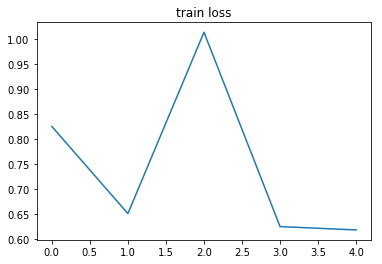

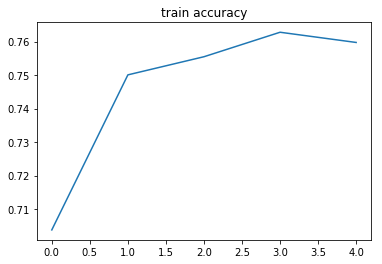

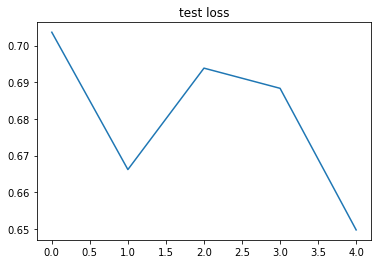

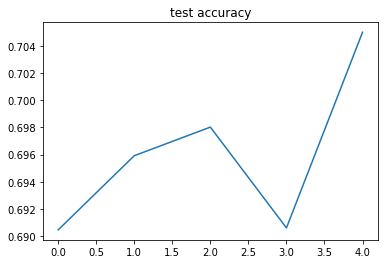

In [13]:
import matplotlib.pyplot as plt

plt.title('train loss')
plt.plot(loss_train)
plt.show()

plt.title('train accuracy')
plt.plot(acc_train)
plt.show()

plt.title('test loss')
plt.plot(loss_validation)
plt.show()

plt.title('test accuracy')
plt.plot(acc_validation)
plt.show()

## Tips
If you want to drive up your score try following things:

* More layers in blocks
* More epochs
* Increase batch size
* Try to play with learning rate / dropout / optimizer type
* Try different variants of padding ('same')
* Use data augmentation
* Use residual connections
* Spatial Bottleneck Modules
